### Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd 'drive/Othercomputers/My Laptop (1)/MY COLLEGE/ISI KOLKATA/PROJECTS/IIT J Summer Internship 2022/Code/Neural-Uncertainty-Representation/'

/content/drive/Othercomputers/My Laptop (1)/MY COLLEGE/ISI KOLKATA/PROJECTS/IIT J Summer Internship 2022/Code/Neural-Uncertainty-Representation


In [ ]:
import sys
sys.path.insert(0,'drive/Othercomputers/My Laptop (1)/MY COLLEGE/ISI KOLKATA/PROJECTS/IIT J Summer Internship 2022/Code/Neural-Uncertainty-Representation/')

### Importing necessary libraries

In [ ]:
!pip install phate
!pip install scprep

In [12]:
import numpy as np
import phate as ph
import pandas as pd
import scprep as scp
import matplotlib.pyplot as plt

In [13]:
import TPHATE # Temporal PHATE
# 2 Modifications over Vanilla PHATE(Check https://github.com/KrishnaswamyLab/PHATE):
# (a) Calculation of Temporal Affinity Matrix
# (b) Changing the inputs of the Vanilla PHATE class to take the above matrix as input
# (c) Calculation of the Resultant Diffusion Operator as the product of the Vanilla PHATE Diffusion Operator and Temporal Affinity Matrix

### Importing Data

We import the data of a young subject's 3D-Tensor Data of dimensions (TR, Voxel, Number of Subjects) for the 5 different ROIs as follows:
- lOFC
- mOFC
- mPFC
- dmPFC
- vlPFC

In [7]:
data_lOFC = np.load('YOUNG/data_lOFC.npy')
data_mOFC = np.load('YOUNG/data_mOFC.npy')
data_mPFC = np.load('YOUNG/data_mPFC.npy')
data_dmPFC = np.load('YOUNG/data_dmPFC.npy')
data_vlPFC = np.load('YOUNG/data_vlPFC.npy')

We now find the BOLD data for all voxel and all the TRs averaged over the subjects.

In [8]:
data_lOFC_avg = np.mean(data_lOFC, axis=2)
data_mOFC_avg = np.mean(data_mOFC, axis=2)
data_mPFC_avg = np.mean(data_mPFC, axis=2)
data_dmPFC_avg = np.mean(data_dmPFC, axis=2)
data_vlPFC_avg = np.mean(data_vlPFC, axis=2)

In [9]:
data_lOFC_avg.shape

(189, 1700)

### T-PHATE Representation

Here we apply Temporal PHATE Algorithm on the average young subjects BOLD data for each ROI. It differs from the Vanilla PHATE in the following way:
- Temporal Affinity Probability Matrix is calculated by:
  - Estimating the Autocorrelation Function for each voxel's Time Series with lags $0, 1, \dots, TR_{final}-1$.
  - Averaging the Autocorrelation Function($acf$) over the voxels.
  - Finding the first position(lag), where the $acf$ is $0$. Take this as $lag_{max}$.
  - Form the Affinity Matrix as $A$, where $A(i,j) = acf(i,j)$, whenever $0<|i-j|\leq lag_{max}$ and $0$ o.w.
  - Row-Normalize $A$ to obtain the Temporal Affinity Probability Matrix $P_T$
- Modifying the Diffusion Operator($P_D$) of the Vanilla PHATE to take into account the $P_T$ matrix by:
  - Modified Diffusion Operator = $P_D\cdot P_T$
- Carrying on the same operations as in Vanilla PHATE.

Disclaimer:
- The $acf$ function is not smoothed and the $lag_{max}$ is the first value of lag where the $acf$ drops below 0.
- $acf(i,j) = acf(lag=|i-j|)$ i.e. by assumption of stationary time series.

In [15]:
def plot_phate_rep(data, c, ax=None, title="", legend_title=""):
  # We find the temporal affinity matrix --- The Last Function in the TPHATE.py File
  P_T = TPHATE.temporal_affinity_matrix(data)

  # We now instantiate the PHATE operator(matrix)/object of the PHATE class
  phate_op = TPHATE.PHATE(P_T, random_state=43, verbose=0)
  # PHATE requires Voxel x TR Data
  phate_embd =  phate_op.fit_transform(data)
  scp.plot.scatter2d(phate_embd, ax=ax,  c = c, label_prefix='PHATE ', title=title, legend_title=legend_title)

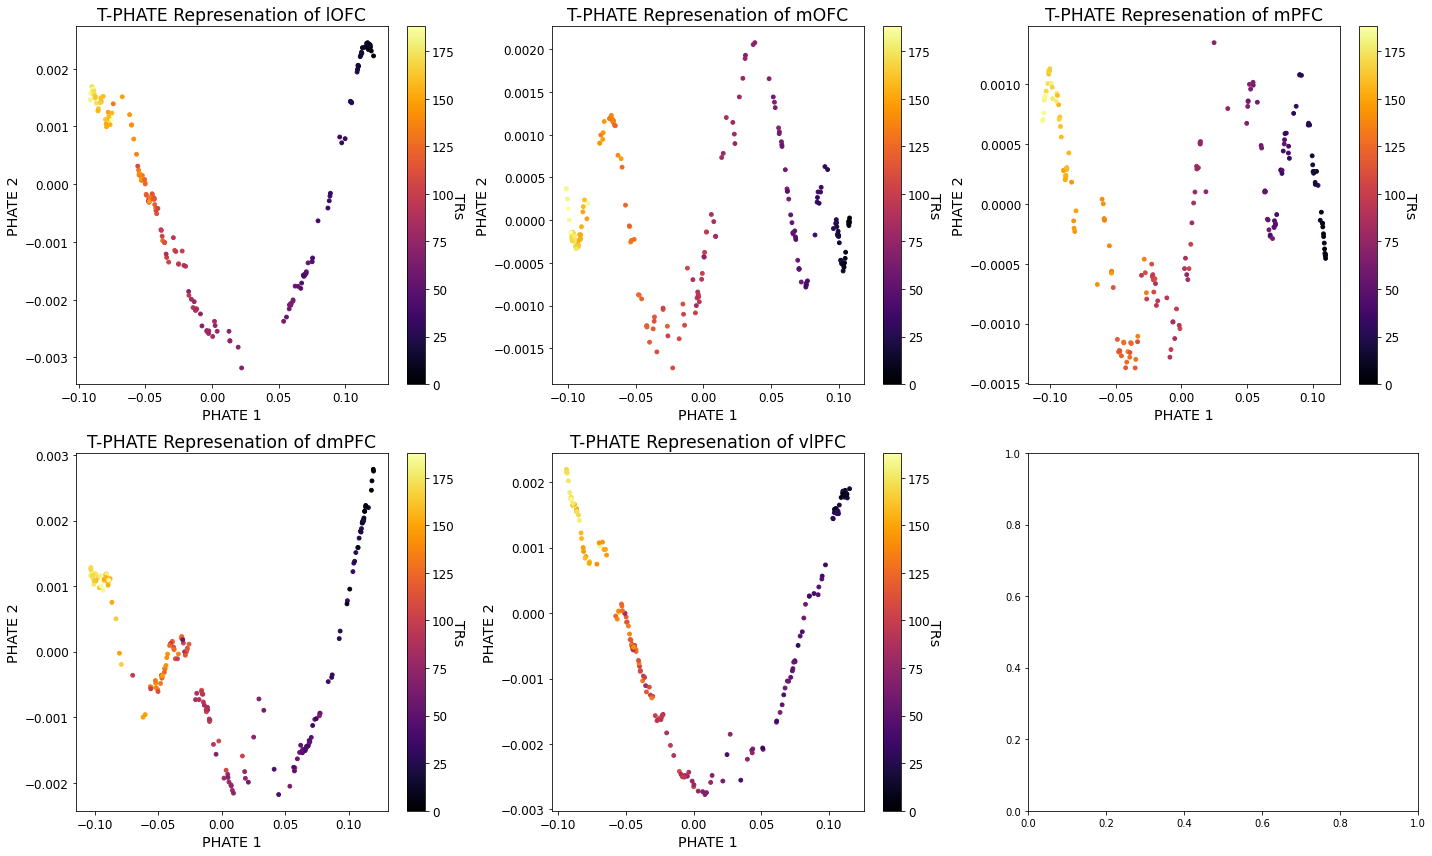

In [16]:
import warnings
warnings.filterwarnings('ignore')

ROIs_data = [data_lOFC_avg, data_mOFC_avg, data_mPFC_avg, data_dmPFC_avg, data_vlPFC_avg]
ROIs = ["lOFC", "mOFC", "mPFC", "dmPFC", "vlPFC"]

fig, ax = plt.subplots(2,3, figsize=(20,12))
i = 0
for name, data in zip(ROIs, ROIs_data):
  plot_phate_rep(data, list(range(data.shape[0])), ax[min(max(0, i-2),1),i%3], "T-PHATE Represenation of "+ name, "TRs")
  i += 1
  fig.tight_layout()

I have color coded each set of Ascent and Descent below, i.e.
- 0 indicates those TRs which are neither ascent and descent. 
- 1 indicates those TRs which are in A1 and D1.
- 2 indicates those TRs which are in A2 and D2.
- 3 indicates those TRs which are in A3 and D3.
- 4 indicates those TRs which are in A4 and A4
- 5 indicates those TRs wiich are in A5 and D5.

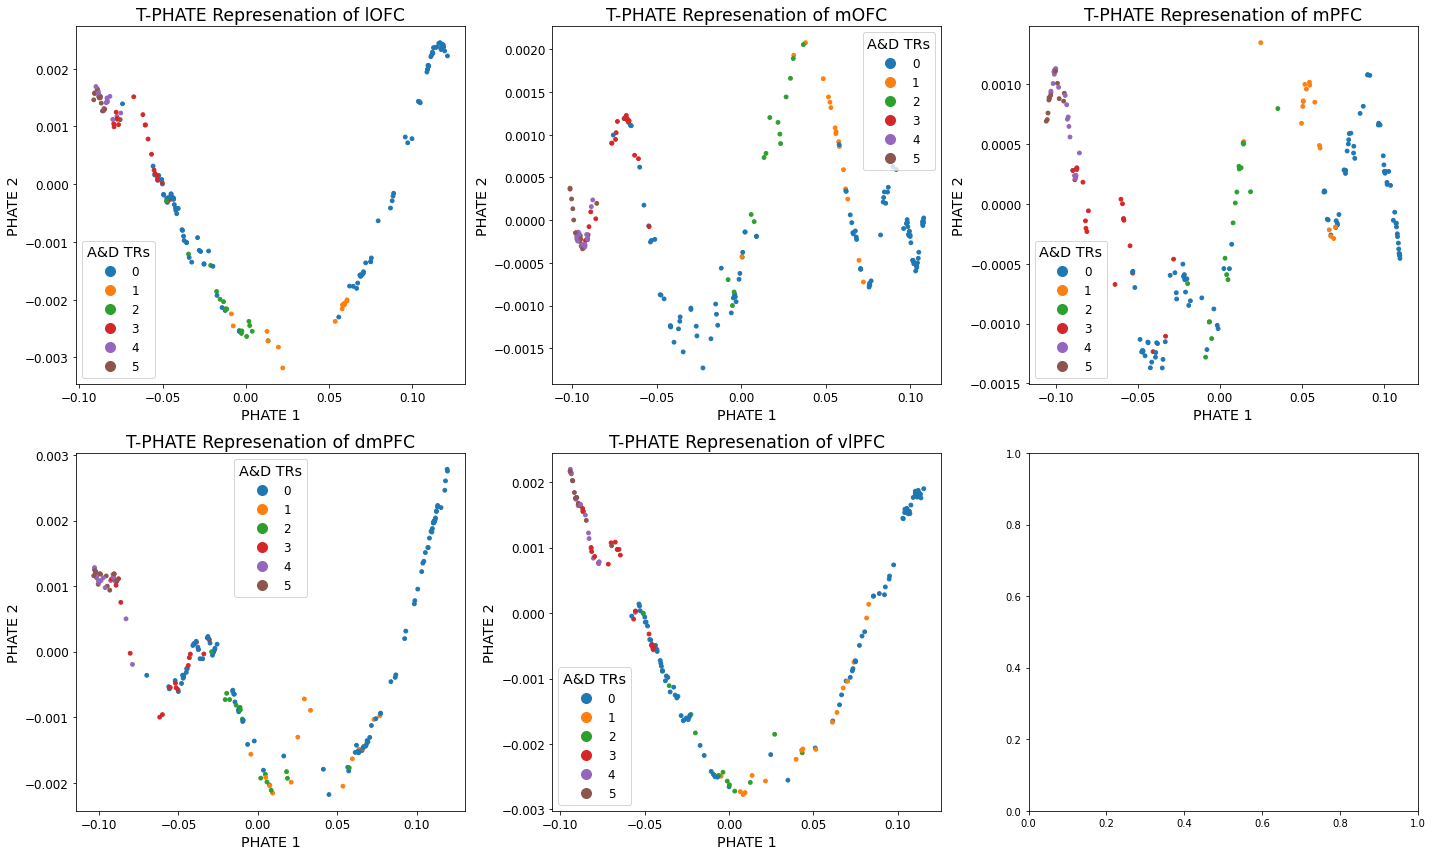

In [28]:
fig, ax = plt.subplots(2,3, figsize=(20,12))
i = 0
for name, data in zip(ROIs, ROIs_data):
  plot_phate_rep(data, [0]*56+[1]*17+[2]*17+[0]*44+[3]*21+[4]*19+[5]*15, ax[min(max(0, i-2),1),i%3], "T-PHATE Represenation of "+ name, "A&D TRs")
  i += 1
  fig.tight_layout()